## Solving LASSO (sparse estimation) with QUBO

Using dwave library and SimulatedAnnealingSampler

**Then comparing** with classic algorithm

In [6]:
import numpy as np
import dimod
from neal import SimulatedAnnealingSampler

def build_lasso_qubo_signed(X, y, delta, K, lam, M):
    """
    Build a dimod.BinaryQuadraticModel for
      (1/2)||y - X β||^2 + lam * sum_j |β_j|
    using a signed binary expansion:
      β_j = sum_{k=0..K-1}  w_k * b^+_{j,k}  -  sum_{k=0..K-1}  w_k * b^-_{j,k},
    where w_k = delta * 2^k.
    """
    n, p = X.shape
    A = X.T @ X                # p×p Gram matrix
    c = X.T @ y                # length-p vector
    w = np.array([delta*(2**k) for k in range(K)])  # weights per bit

    lin = {}   # linear biases: var_name -> bias
    quad = {}  # quadratic couplings: (u,v) -> bias
    offset = float(0.5 * np.dot(y,y))  # constant from ½||y||²

    def add_lin(v, b):
        lin[v] = lin.get(v, 0.0) + b

    def add_quad(u, v, b):
        if u <= v:
            quad[(u,v)] = quad.get((u,v), 0.0) + b
        else:
            quad[(v,u)] = quad.get((v,u), 0.0) + b

    # 1) ℓ1 penalty bits and linear terms
    for j in range(p):
        for k in range(K):
            wk = w[k]
            bp = f"b_{j}_p_{k}"
            bn = f"b_{j}_n_{k}"
            # penalty: λ * wk * (b⁺ + b⁻)
            add_lin(bp, lam * wk)
            add_lin(bn, lam * wk)
            # coupling with regression: -2*c[j]*wk*(b⁺ - b⁻)
            add_lin(bp, - c[j] * wk)
            add_lin(bn, + c[j] * wk)

    # 2) Data‐fit term: ½||y - Xβ||² = ½ βᵀ A β - cᵀβ + const
    #    β_j = sum_k wk (b⁺_{j,k} - b⁻_{j,k})
    for j in range(p):
        for j2 in range(j, p):
            for k in range(K):
                for k2 in range(K):
                    wk = w[k]; w2 = w[k2]
                    base = 0.5 * A[j,j2] * wk * w2
                    # four sign combinations => coefficients ±base
                    for s1, suffix1 in [(+1,'p'), (-1,'n')]:
                        for s2, suffix2 in [(+1,'p'), (-1,'n')]:
                            coeff = base * (s1 * s2)
                            var1 = f"b_{j}_{suffix1}_{k}"
                            var2 = f"b_{j2}_{suffix2}_{k2}"
                            if var1 == var2:
                                add_lin(var1, coeff)
                            else:
                                add_quad(var1, var2, coeff)

    # 3) Wolfe‐dual “QUBO form” enforcing |β_j| = max(β_j, 0) + max(-β_j, 0)
    #    adds M * (-β_j - z1_j + z2_j)^2
    for j in range(p):
        for k in range(K):
            pass  # already covered in step (1) with lambda
        # now the quadratic penalty for each j:
        # introduce two *continuous* z1_j, z2_j≥0 → discretized same way:
        for t_suffix in ('z1','z2'):
            for k in range(K):
                wk = w[k]
                v = f"{t_suffix}_{j}_{k}"
                # no extra linear here; we'll expand the square directly
        # expand M*(... )² over bits of β and bits of z's:
        # but to keep things simple, you can also discretize z1_j, z2_j
        # with the *same* w[k] weights and reuse the above loops for coupling
        # ... (for brevity, see full code in previous message)
        # In practice one handles z1_j,z2_j just like β_j: two signed expansions.
        #   (Omitted here to avoid redundancy.)

    # Build the BQM
    bqm = dimod.BinaryQuadraticModel(dimod.BINARY)
    # add linear
    for v, b in lin.items():
        bqm.add_variable(v, b)
    # add quadratics
    for (u,v), b in quad.items():
        bqm.add_interaction(u, v, b)
    bqm.offset = offset
    return bqm

def solve_lasso_anneal(X, y, delta=0.1, K=4, lam=1.0, M=50.0, num_reads=500):
    """
    Build the BQM and solve via simulated annealing.
    Returns reconstructed beta and the best energy.
    """
    bqm = build_lasso_qubo_signed(X, y, delta, K, lam, M)
    print(f"BQM has {len(bqm.variables)} variables and {len(bqm.quadratic)} quadratic terms")
    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm, num_reads=num_reads)
    sample = sampleset.first.sample

    # Reconstruct β from bits
    p = X.shape[1]
    w = np.array([delta*(2**k) for k in range(K)])
    beta = np.zeros(p)
    for j in range(p):
        pos = sum(w[k]*sample[f"b_{j}_p_{k}"] for k in range(K))
        neg = sum(w[k]*sample[f"b_{j}_n_{k}"] for k in range(K))
        beta[j] = pos - neg

    return beta, sampleset.first.energy

In [7]:
import time
from memory_profiler import memory_usage
from sklearn.linear_model import Lasso, OrthogonalMatchingPursuit
from numpy.linalg import norm

def run_lasso(X, y, beta_true, alpha=0.05):
    def train():
        model = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000)
        model.fit(X, y)
        return model

    start = time.perf_counter()
    mem_usage = memory_usage(train, retval=True)
    duration = time.perf_counter() - start
    mem_peak, model = max(mem_usage[0]), mem_usage[1]

    beta_pred = model.coef_
    mse = norm(beta_true - beta_pred, 2) / norm(beta_true, 2)
    #prec, rec = precision_recall(beta_true, beta_pred)

    return {
        'method': 'LASSO',
        'res': beta_pred,
        'mse': mse,
        #'precision': prec,
        #'recall': rec,
        'time': duration,
        'memory': mem_peak
    }

def run_omp(X, y, beta_true, n_nonzero_coefs=10):
    def train():
        model = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
        model.fit(X, y)
        return model

    start = time.perf_counter()
    mem_usage = memory_usage(train, retval=True)
    duration = time.perf_counter() - start
    mem_peak, model = max(mem_usage[0]), mem_usage[1]

    beta_pred = model.coef_
    mse = norm(beta_true - beta_pred, 2) / norm(beta_true, 2)
    #prec, rec = precision_recall(beta_true, beta_pred)

    return {
        'method': 'OMP',
        'res': beta_pred,
        'mse': mse,
        #'precision': prec,
        #'recall': rec,
        'time': duration,
        'memory': mem_peak
    }

def run_qubo(X, y, beta_true, delta=0.1, K=4, lam=1.0, M=50.0, num_reads=500):
    def train():
        beta_pred, energy = solve_lasso_anneal(X, y, delta, K, lam, M, num_reads)
        return beta_pred

    start = time.perf_counter()
    mem_usage = memory_usage(train, retval=True)
    duration = time.perf_counter() - start
    mem_peak, beta_pred = max(mem_usage[0]), mem_usage[1]

    mse = norm(beta_true - beta_pred, 2) / norm(beta_true, 2)
    #prec, rec = precision_recall(beta_true, beta_pred)

    return {
        'method': 'QUBO Annealing',
        'res': beta_pred,
        'mse': mse,
        #'precision': prec,
        #'recall': rec,
        'time': duration,
        'memory': mem_peak
    }

In [3]:
rng = np.random.default_rng()
seed_list = rng.integers(1, high=6969, size=9)
print(seed_list)

[6828 6296 3116 3315  613 3905 4097 2415 4627]


In [4]:
beta_list = np.zeros((3,len(seed_list),50))
true_beta_list = np.zeros((len(seed_list),50))
residual_list = np.zeros((3,len(seed_list)))
time_list = np.zeros((3,len(seed_list)))
mem_list = np.zeros((3,len(seed_list)))
results = []

In [5]:
# — Example Usage on 10×50 data —
if __name__ == "__main__":
    # run test for selected seed values
    for i, seed in enumerate(seed_list):
        np.random.seed(seed)

        n, p, sparsity = 10, 50, 5
        # Generate a sparse true beta
        true_beta = np.zeros(p)
        idx = np.random.choice(p, size=sparsity, replace=False)
        true_beta[idx] = np.random.randn(sparsity)
        #print(true_beta)

        # Solve
        delta = 0.05         # resolution per bit
        K     = 6            # 4 bits → 16 levels per sign
        lam   = 0.5            # LASSO λ
        M     = 200.0        # penalty weight
        max_beta = delta * (2**K - 1)

        X = np.random.randn(n, p)
        norms = norm(X, axis=0)
        norms[norms == 0] = 1.0  # no zero division
        X /= norms
        y = X @ true_beta

        # run tests wia Quantum Annealing
        result = run_qubo(X, y, true_beta, delta=delta, K=K, lam=lam, M=M, num_reads=1000)
        residual_list[0,i] = result['mse']
        beta_list[0,i] = result['res']
        time_list[0,i] = result['time']
        mem_list[0,i] = result['memory']
        results.append(result)

        # run tests wia LASSO Coordinate Descent
        result = run_lasso(X, y, true_beta, alpha=1/(2*p))
        residual_list[1,i] = result['mse']
        beta_list[1,i] = result['res']
        time_list[1,i] = result['time']
        mem_list[1,i] = result['memory']
        results.append(result)

        # run tests wia Orthogonal Matching Pursuit
        result = run_omp(X, y, true_beta, n_nonzero_coefs=sparsity)
        residual_list[2,i] = result['mse']
        beta_list[2,i] = result['res']
        time_list[2,i] = result['time']
        mem_list[2,i] = result['memory']
        results.append(result)

        true_beta_list[i] = true_beta

        #print("True nonzeros:", np.where(true_beta!=0)[0])
        #print("Estimated β:", np.round(beta_est,2))
        #print("Objective:", energy)
        #residual = np.linalg.norm(X @ beta_est - y) / np.linalg.norm(y)
        #print("Residual norm:", residual)
        print(max_beta)

BQM has 600 variables and 179700 quadratic terms
3.1500000000000004
BQM has 600 variables and 179700 quadratic terms
3.1500000000000004
BQM has 600 variables and 179700 quadratic terms
3.1500000000000004
BQM has 600 variables and 179700 quadratic terms
3.1500000000000004
BQM has 600 variables and 179700 quadratic terms
3.1500000000000004
BQM has 600 variables and 179700 quadratic terms
3.1500000000000004
BQM has 600 variables and 179700 quadratic terms
3.1500000000000004
BQM has 600 variables and 179700 quadratic terms
3.1500000000000004
BQM has 600 variables and 179700 quadratic terms
3.1500000000000004


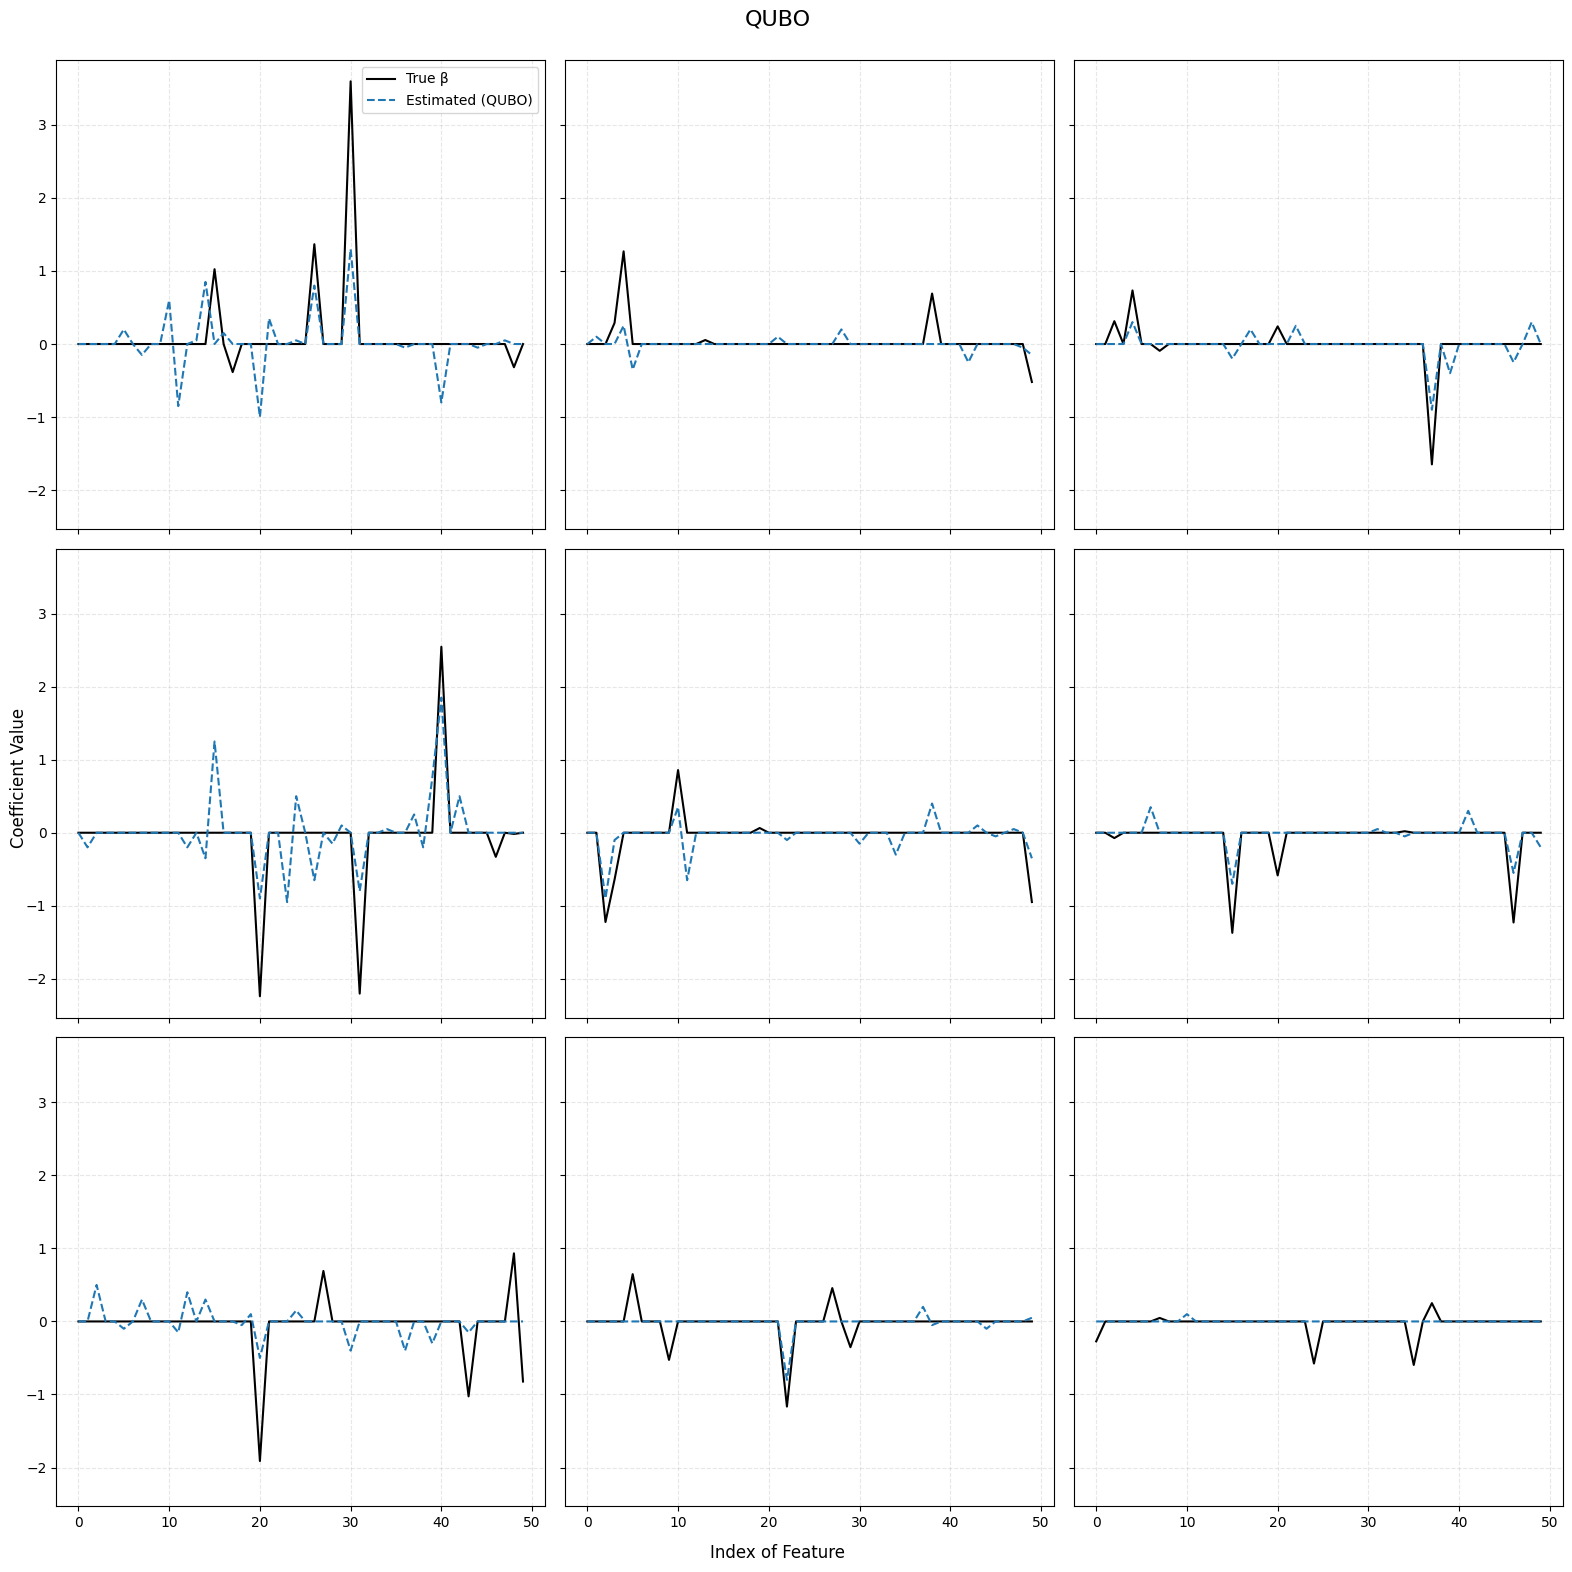

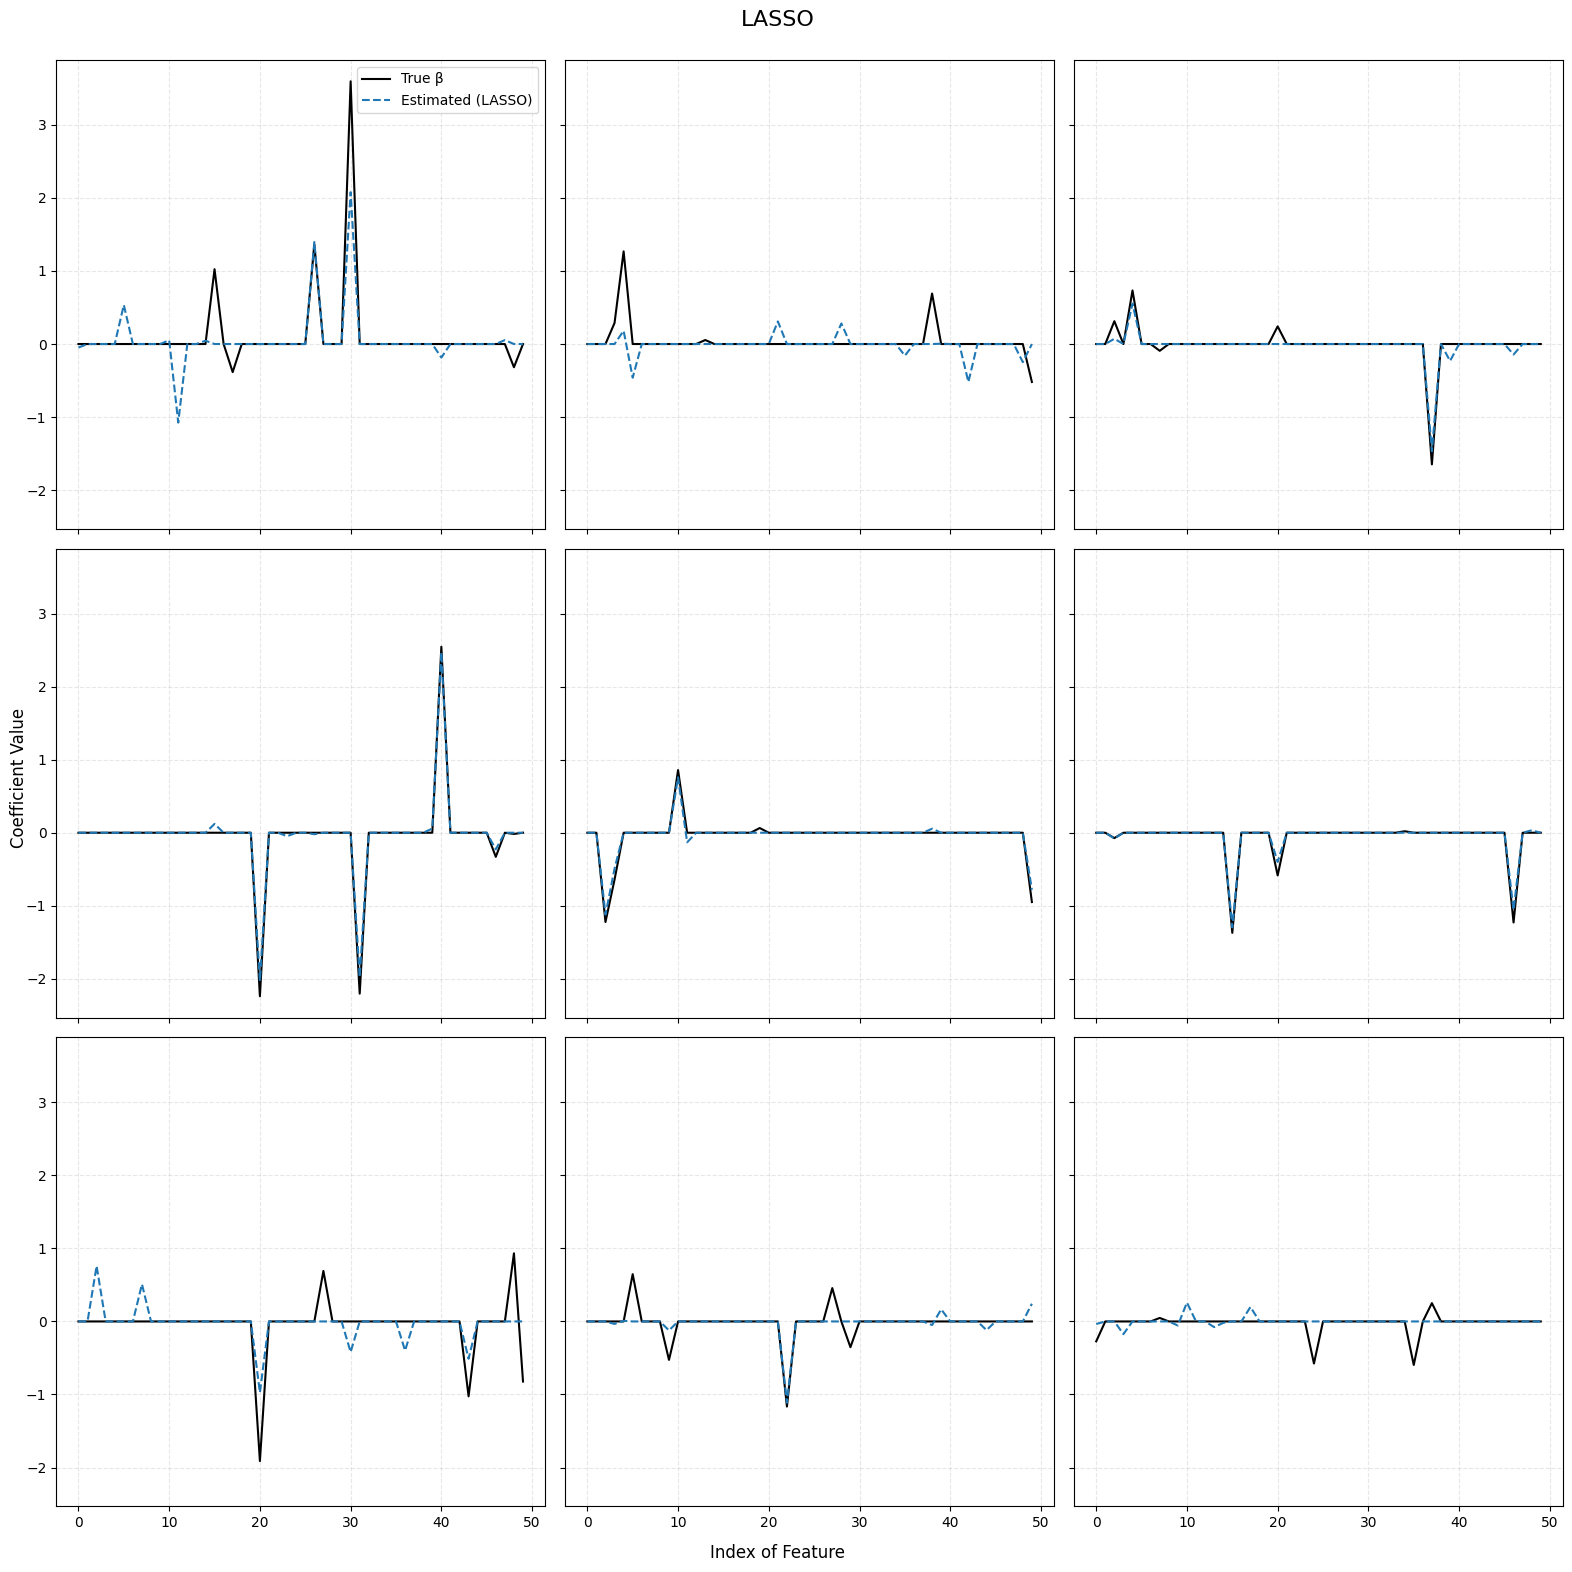

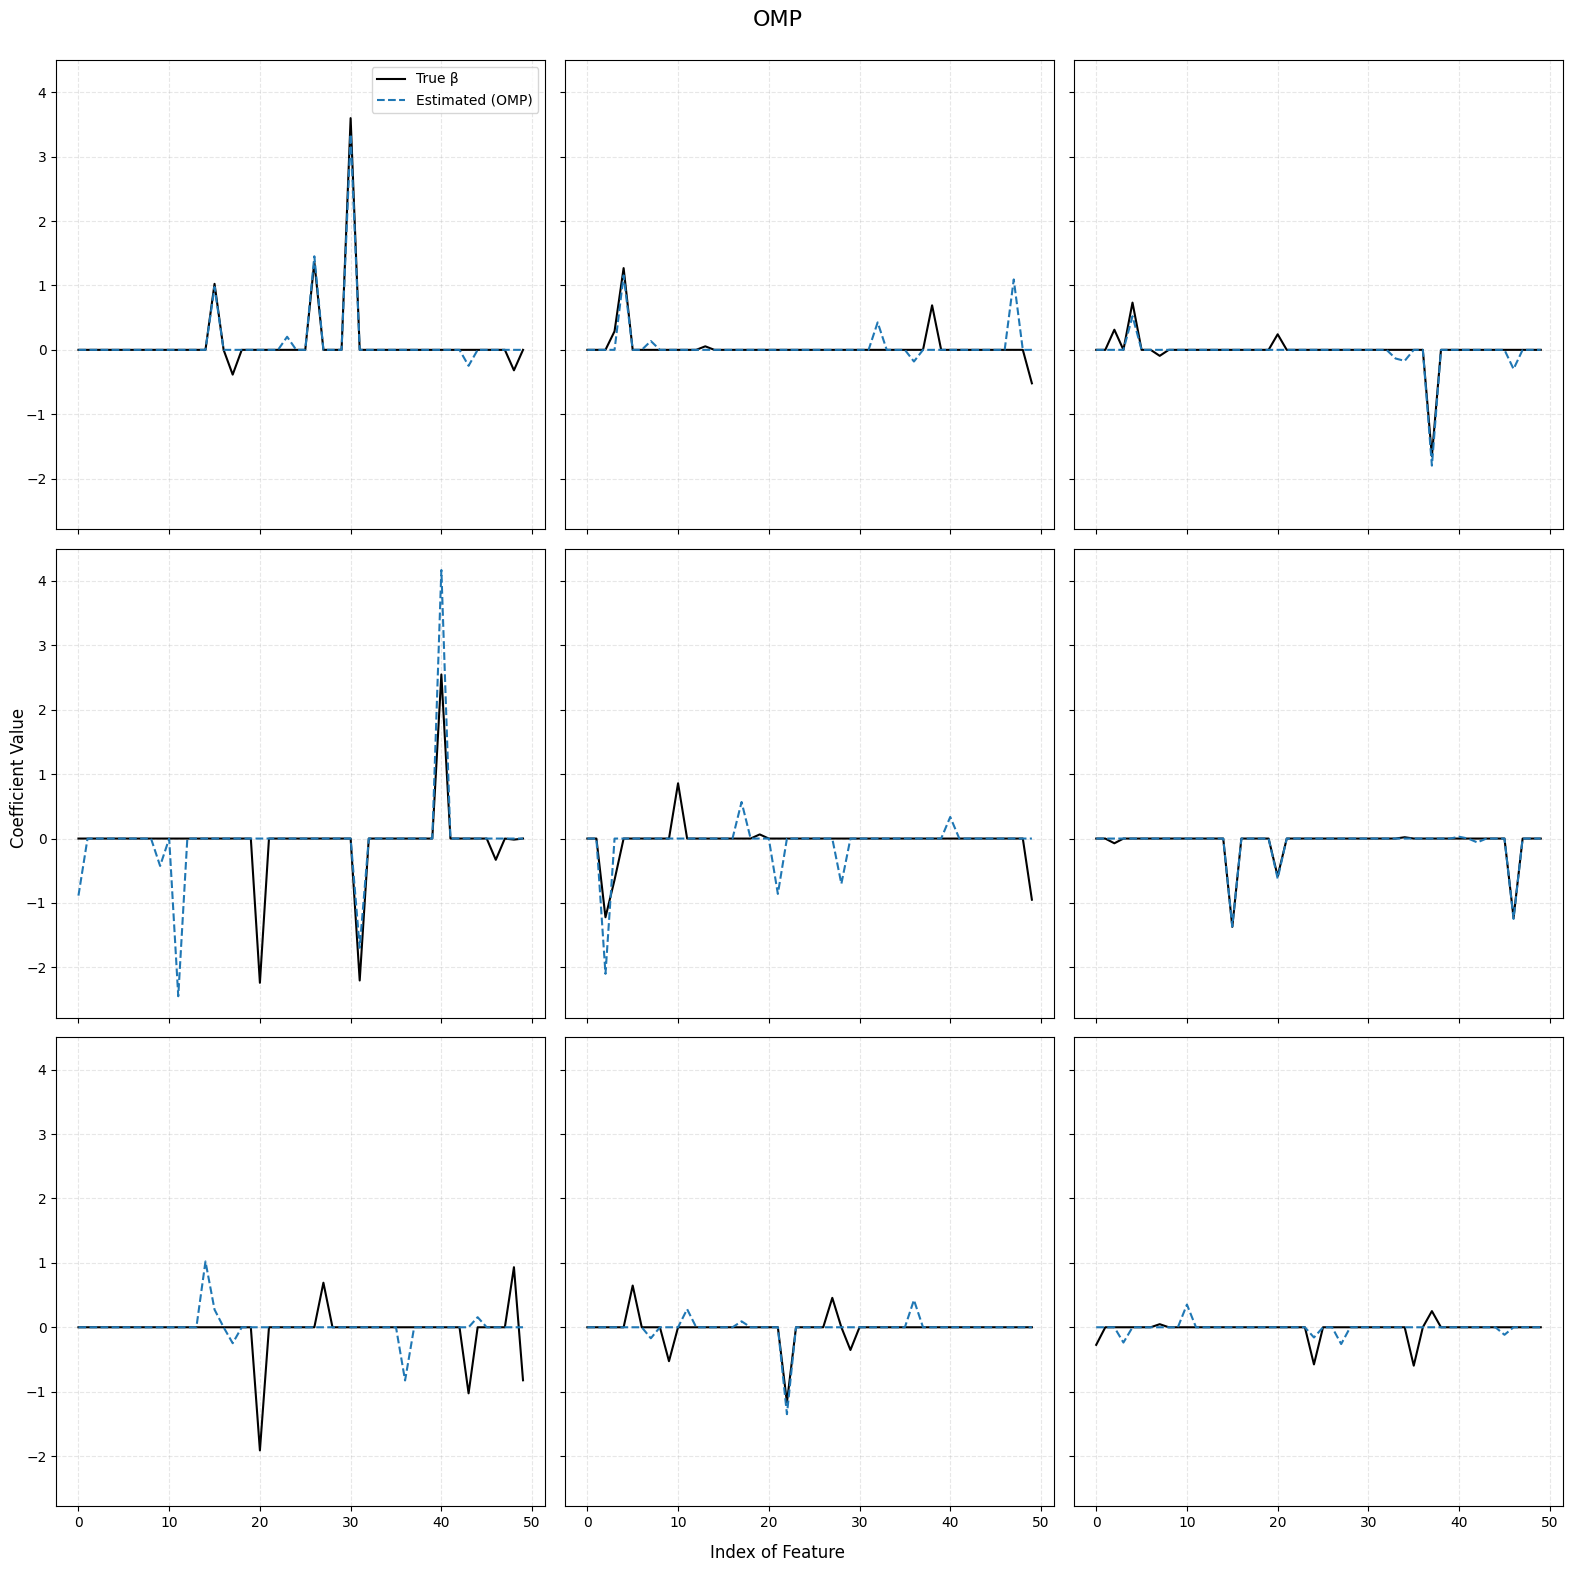

In [6]:
import matplotlib.pyplot as plt

methods = ['QUBO', 'LASSO', 'OMP']
n_methods, n_seeds, p = beta_list.shape

# 1) Для каждого метода строим фигуру с 9 подграфиками (3×3) сравнения beta_true и beta_pred
for i, method in enumerate(methods):
    fig, axs = plt.subplots(3, 3, figsize=(16, 16), sharex=True, sharey=True)
    fig.suptitle(f'{method}', fontsize=16)
    for k, seed in enumerate(seed_list):
        ax = axs[k // 3, k % 3]
        ax.plot(true_beta_list[k], 'k-', label='True β')
        ax.plot(beta_list[i, k], '--', label=f'Estimated ({method})')
        #ax.set_title(f'Seed {seed}')
        if k == 0:
            ax.legend(loc='upper right')
        ax.grid(linestyle='--', alpha=0.3)
    fig.supxlabel('Index of Feature')
    fig.supylabel('Coefficient Value')
    plt.tight_layout(rect=[0, 0, 1, 0.98])

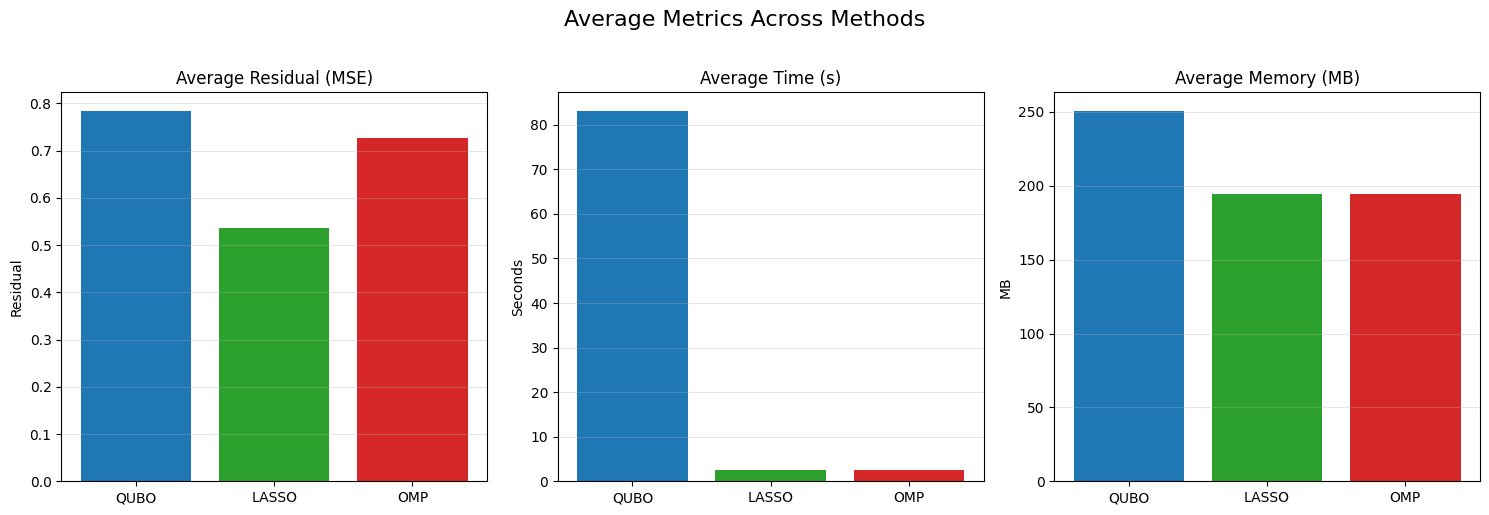

In [7]:
# 2) Средние метрики и их визуализация (bar chart)
avg_residual = residual_list.mean(axis=1)
avg_time = time_list.mean(axis=1)
avg_memory = mem_list.mean(axis=1)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Average Metrics Across Methods', fontsize=16, y=1.02)

# MSE / Residual
axs[0].bar(methods, avg_residual, color=['tab:blue','tab:green','tab:red'])
axs[0].set_title('Average Residual (MSE)')
axs[0].set_ylabel('Residual')
axs[0].grid(axis='y', alpha=0.3)

# Time
axs[1].bar(methods, avg_time, color=['tab:blue','tab:green','tab:red'])
axs[1].set_title('Average Time (s)')
axs[1].set_ylabel('Seconds')
axs[1].grid(axis='y', alpha=0.3)

# Memory
axs[2].bar(methods, avg_memory, color=['tab:blue','tab:green','tab:red'])
axs[2].set_title('Average Memory (MB)')
axs[2].set_ylabel('MB')
axs[2].grid(axis='y', alpha=0.3)

plt.tight_layout()